# Model Loading and Inference for Missing Wealth

This code **reconstructs** a previously trained model from the CSV logs and a saved checkpoint (`.pth`), then **fills missing wealth values** in a GeoDataFrame.

- **`load_model_from_csv_and_checkpoint`**:
  1. Reads a log CSV to find the row with the specified `model_name`.  
  2. Parses stored hyperparameters (`backbone`, `mlp_layers`, `dropout`, etc.) and channels used.  
  3. Rebuilds a matching CNN architecture (same number of input channels, same MLP head).  
  4. Loads the `.pth` checkpoint for that model.  

- **`predict_missing_wealth_auto`**:
  1. Loads the specified model from the CSV (or does nothing if `model_name` is `None`).  
  2. Reads a GPKG with missing `weighted_wealth` values, identifies those rows, and **predicts** new wealth indices using the model.  
  3. Updates the GeoDataFrame in place, marking which rows were predicted (`predicted_flag=True`).

In [2]:
import pandas as pd
import ast
import os
import torch
import numpy as np
import geopandas as gpd
from torch import nn
from torchvision.models import (ResNet18_Weights, ResNet50_Weights, 
                                EfficientNet_B0_Weights, 
                                ConvNeXt_Tiny_Weights, 
                                resnet18, resnet50, 
                                efficientnet_b0, convnext_tiny)
from tqdm import tqdm
import torchvision.transforms as T

# Make sure the channel ranges are exactly as in training.
CHANNEL_RANGES = {
    "sentinel_rgb":       (0, 255),    # 3 sub-channels: R, G, B
    "sentinel_ndvi":      (0, 255),
    "sentinel_built_up":  (0, 255),
    "sentinel_nir":       (0, 65535),
    "sentinel_swir1":     (0, 65535),
    "sentinel_swir2":     (0, 65535),
    "viirs_nightlights":  (0, 65535),
    "viirs_gradient":     (0, 65535),
}

def scale_channels(data, channels_to_use):
    """
    Scales each channel in the NPZ file to [0, 1] using CHANNEL_RANGES.
    """
    arrays = []
    for ch in channels_to_use:
        arr = data[ch]
        if arr.ndim == 2:
            arr = arr[..., None]
        ch_min, ch_max = CHANNEL_RANGES[ch]
        arr = (arr - ch_min) / (ch_max - ch_min + 1e-8)
        arrays.append(arr.astype(np.float32))
    combined = np.concatenate(arrays, axis=-1)
    return combined

def load_model_from_csv_and_checkpoint(
    model_name,
    results_csv,
    base_model_dir="data/Results/Models",
    device=None,
    freeze_cnn=False   # If True, freeze the backbone.
):
    """
    Loads a model by reading its hyperparameters from `results_csv` (matching model_name),
    reconstructs the backbone+MLP (with proper weight initialization), and loads its .pth file.
    
    Returns (model, channels_to_use).
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() 
                              else "cuda" if torch.cuda.is_available() 
                              else "cpu")
        print(f"Using device: {device}")
    
    df = pd.read_csv(results_csv)
    match_df = df[df['model_name'] == model_name]
    if len(match_df) == 0:
        raise ValueError(f"No entry found for model_name='{model_name}' in CSV: {results_csv}")
    row = match_df.iloc[-1]
    
    def parse_bool(val):
        return bool(val) if isinstance(val, int) else (str(val).lower()=='true')
    
    backbone = row['backbone']
    pretrained = parse_bool(row['pretrained'])
    dropout = float(row['dropout'])
    mlp_layers = ast.literal_eval(row['mlp_layers'])
    channels_str = ast.literal_eval(row['channels_to_use'])
    
    num_in_channels = sum((3 if c == "sentinel_rgb" else 1) for c in channels_str)
    
    class FlexibleRegressor(nn.Module):
        def __init__(self, num_in_channels, backbone='resnet18', pretrained=True, mlp_layers=[256], dropout=0.2, freeze_cnn=False):
            super().__init__()
            if backbone == 'resnet18':
                if pretrained:
                    self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = resnet18(weights=None)
                num_features = 512
            elif backbone == 'resnet50':
                if pretrained:
                    self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = resnet50(weights=None)
                num_features = 2048
            elif backbone == 'efficientnet_b0':
                if pretrained:
                    self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = efficientnet_b0(weights=None)
                num_features = 1280
            elif backbone == 'convnext_tiny':
                if pretrained:
                    self.backbone = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = convnext_tiny(weights=None)
                num_features = 768
            else:
                raise ValueError(f"Unsupported backbone: {backbone}")
            
            self._replace_first_conv(num_in_channels, backbone)
            
            if backbone.startswith('resnet'):
                self.backbone.fc = nn.Identity()
            elif backbone == 'efficientnet_b0':
                self.backbone.classifier = nn.Identity()
            elif backbone == 'convnext_tiny':
                self.backbone.classifier[2] = nn.Identity()
            
            mlp = []
            prev_dim = num_features
            for hidden_dim in mlp_layers:
                linear_layer = nn.Linear(prev_dim, hidden_dim)
                nn.init.xavier_uniform_(linear_layer.weight)
                if linear_layer.bias is not None:
                    nn.init.constant_(linear_layer.bias, 0)
                mlp.append(linear_layer)
                mlp.append(nn.ReLU())
                if dropout > 0:
                    mlp.append(nn.Dropout(dropout))
                prev_dim = hidden_dim
            final_linear = nn.Linear(prev_dim, 1)
            nn.init.xavier_uniform_(final_linear.weight, gain=0.1)
            if final_linear.bias is not None:
                nn.init.constant_(final_linear.bias, 0)
            mlp.append(final_linear)
            mlp.append(nn.Sigmoid())
            self.mlp = nn.Sequential(*mlp)
            
            if freeze_cnn:
                for param in self.backbone.parameters():
                    param.requires_grad = False
        
        def _replace_first_conv(self, num_in_channels, backbone):
            if backbone in ['resnet18', 'resnet50']:
                old_conv = self.backbone.conv1
                old_weights = old_conv.weight.data
                new_conv = nn.Conv2d(
                    in_channels=num_in_channels,
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=False
                )
                copy_ch = min(3, num_in_channels)
                new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
                if num_in_channels > 3:
                    nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
                self.backbone.conv1 = new_conv
            elif backbone == 'efficientnet_b0':
                old_conv = self.backbone.features[0][0]
                old_weights = old_conv.weight.data
                new_conv = nn.Conv2d(
                    in_channels=num_in_channels,
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=False
                )
                copy_ch = min(3, num_in_channels)
                new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
                if num_in_channels > 3:
                    nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
                self.backbone.features[0][0] = new_conv
            elif backbone == 'convnext_tiny':
                old_conv = self.backbone.features[0][0]
                old_weights = old_conv.weight.data
                new_conv = nn.Conv2d(
                    in_channels=num_in_channels,
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=False
                )
                copy_ch = min(3, num_in_channels)
                new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
                if num_in_channels > 3:
                    nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
                self.backbone.features[0][0] = new_conv
            else:
                raise ValueError(f"Unhandled backbone: {backbone}")
        
        def forward(self, x):
            features = self.backbone(x)
            return self.mlp(features)
    
    model = FlexibleRegressor(
        num_in_channels=num_in_channels,
        backbone=backbone,
        pretrained=pretrained,
        mlp_layers=mlp_layers,
        dropout=dropout,
        freeze_cnn=freeze_cnn
    ).to(device)
    
    checkpoint_path = os.path.join(base_model_dir, f"{model_name}.pth")
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    
    print(f"Loaded model '{model_name}': {backbone}, pretrained={pretrained}, mlp={mlp_layers}, dropout={dropout}, freeze_cnn={freeze_cnn}")
    return model, channels_str

def predict_missing_wealth_auto(
    gpkg_path,
    country,
    year,
    model_name,
    results_csv,
    base_model_dir="data/Results/Models",
    transform=None,
    device=None,
    freeze_cnn=False
):
    """
    Uses a loaded model (by name) to fill missing 'weighted_wealth' in a GPKG.
    """
    if model_name is None:
        print("No model_name provided; skipping predictions.")
        gdf = gpd.read_file(gpkg_path)
        gdf['predicted_flag'] = False
        return gdf
    
    model, channels_to_use = load_model_from_csv_and_checkpoint(
        model_name=model_name,
        results_csv=results_csv,
        base_model_dir=base_model_dir,
        device=device,
        freeze_cnn=freeze_cnn
    )
    
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() 
                              else "cuda" if torch.cuda.is_available() 
                              else "cpu")
        print(f"Using device: {device}")
    
    gdf = gpd.read_file(gpkg_path)
    # Optionally limit number of rows for testing:
    # gdf = gdf.head(1000)
    gdf['predicted_flag'] = False
    missing_mask = gdf['weighted_wealth'].isna()
    missing_indices = gdf.index[missing_mask]
    print(f"Found {len(missing_indices)} rows with NaN in weighted_wealth. Predicting...")
    
    for idx in tqdm(missing_indices):
        cell_id = gdf.at[idx, 'cell_id']
        npz_path = f"data/Results/SatelliteImageData/Images/Combined/{country}/{year}/cell_{cell_id}/combined_data.npz"
        if not os.path.isfile(npz_path):
            continue
        
        data = np.load(npz_path)
        # Apply the same per-channel scaling as in training.
        combined = scale_channels(data, channels_to_use)
        
        # Apply transform if provided; otherwise convert to tensor and permute to [C,H,W].
        if transform:
            combined_tensor = transform(combined)
        else:
            combined_tensor = torch.from_numpy(combined).permute(2, 0, 1)
        
        combined_tensor = combined_tensor.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(combined_tensor).item()
        
        gdf.at[idx, 'weighted_wealth'] = pred
        gdf.at[idx, 'predicted_flag'] = True
    
    print("Prediction complete. Missing wealth values have been filled.")
    return gdf

class ToTensor:
    """Converts a (H, W, C) numpy array to a torch.FloatTensor of shape (C, H, W)."""
    def __call__(self, sample):
        return torch.from_numpy(sample).permute(2, 0, 1)

transform = T.Compose([
#    RandomFlipAndRotate(p=0.5),
    ToTensor()
])

In [ ]:
csv_path = "data/Results/Models/TrainingResultsLog.csv"  # CSV with training log and hyperparameters

output_dir = "data/Results/LabelledGrids"

countries = ['Senegal']
years = ['2016', '2017', '2018', '2019', '2023']

model_name = 'final_model'

master_gdf = gpd.GeoDataFrame()
for country in countries:
    for year in years:
        wealth_index_file = f"data/Results/LabelledGrids/{country}_{year}_wealthindex_labelled.gpkg"
        updated_gdf = predict_missing_wealth_auto(
            gpkg_path=wealth_index_file,
            country=country,
            year=year,
            model_name=model_name,
            results_csv=csv_path,
            base_model_dir="data/Results/Models",
            transform=transform
        )
        updated_gdf.to_file(f"{output_dir}/{country}_{year}_wealthindex_labelled_inferred.gpkg", driver='GPKG')
        updated_gdf['year'] = year
        updated_gdf['country'] = country
        master_gdf = pd.concat([master_gdf, updated_gdf])

Using device: mps
Loaded model 'final_model': efficientnet_b0, pretrained=True, mlp=[64, 32], dropout=0.05, freeze_cnn=False
Using device: mps
Found 7395 rows with NaN in weighted_wealth. Predicting...


100%|██████████| 7395/7395 [03:40<00:00, 33.60it/s]


Prediction complete. Missing wealth values have been filled.
Using device: mps
Loaded model 'final_model': efficientnet_b0, pretrained=True, mlp=[64, 32], dropout=0.05, freeze_cnn=False
Using device: mps
Found 7092 rows with NaN in weighted_wealth. Predicting...


100%|██████████| 7092/7092 [03:28<00:00, 33.94it/s]


Prediction complete. Missing wealth values have been filled.
Using device: mps
Loaded model 'final_model': efficientnet_b0, pretrained=True, mlp=[64, 32], dropout=0.05, freeze_cnn=False
Using device: mps
Found 7406 rows with NaN in weighted_wealth. Predicting...


100%|██████████| 7406/7406 [03:47<00:00, 32.60it/s]


Prediction complete. Missing wealth values have been filled.
Using device: mps
Loaded model 'final_model': efficientnet_b0, pretrained=True, mlp=[64, 32], dropout=0.05, freeze_cnn=False
Using device: mps
Found 7405 rows with NaN in weighted_wealth. Predicting...


100%|██████████| 7405/7405 [03:51<00:00, 31.99it/s]


Prediction complete. Missing wealth values have been filled.
Using device: mps
Loaded model 'final_model': efficientnet_b0, pretrained=True, mlp=[64, 32], dropout=0.05, freeze_cnn=False
Using device: mps
Found 7105 rows with NaN in weighted_wealth. Predicting...


100%|██████████| 7105/7105 [03:42<00:00, 31.96it/s]


Prediction complete. Missing wealth values have been filled.


In [4]:
master_gdf_only_pred = master_gdf[master_gdf['predicted_flag'] == True]
master_gdf_only_true_label = master_gdf[master_gdf['predicted_flag'] == False]
# sort bei weighted_wealth
master_gdf_only_pred.sort_values(by='weighted_wealth', inplace=True)
master_gdf_only_pred.reset_index(drop=True, inplace=True)

master_gdf

/var/folders/z_/86v4rkcx42l5ny9cxfq86xpr0000gn/T/ipykernel_1379/4038365201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_gdf_only_pred.sort_values(by='weighted_wealth', inplace=True)


,cell_id,total_area,covered_area,coverage_percent,weighted_wealth,geometry,predicted_flag,year,country
0,0,25000000.0,1.754864e+07,70.194556,0.688859,"POLYGON ((236184.389 1627011.981, 236184.389 1...",False,2016,Senegal
1,1,25000000.0,5.415231e+06,21.660923,0.657117,"POLYGON ((241184.389 1622011.981, 241184.389 1...",True,2016,Senegal
2,2,25000000.0,9.493621e+06,37.974484,0.658163,"POLYGON ((241184.389 1627011.981, 241184.389 1...",False,2016,Senegal
3,3,25000000.0,1.025354e+07,41.014180,0.675795,"POLYGON ((241184.389 1632011.981, 241184.389 1...",False,2016,Senegal
4,4,25000000.0,2.338526e+07,93.541044,0.638897,"POLYGON ((246184.389 1632011.981, 246184.389 1...",False,2016,Senegal
...,...,...,...,...,...,...,...,...,...
7919,7919,25000000.0,0.000000e+00,0.000000,0.531849,"POLYGON ((891184.389 1442011.981, 891184.389 1...",True,2023,Senegal
7920,7920,25000000.0,0.000000e+00,0.000000,0.367913,"POLYGON ((896184.389 1377011.981, 896184.389 1...",True,2023,Senegal
7921,7921,25000000.0,0.000000e+00,0.000000,0.387963,"POLYGON ((896184.389 1382011.981, 896184.389 1...",True,2023,Senegal
7922,7922,25000000.0,0.000000e+00,0.000000,0.442459,"POLYGON ((896184.389 1412011.981, 896184.389 1...",True,2023,Senegal


In [5]:
# Build file paths for the satellite image data
satellite_images_filepaths = []
for idx, row in master_gdf_only_pred.iterrows():
    country = row['country']
    year = row['year']
    cell_id = row['cell_id']
    path = f"data/Results/SatelliteImageData/Images/Combined/{country}/{year}/cell_{cell_id}/combined_data.npz"
    satellite_images_filepaths.append(path)

# Define plotting function and interactive widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def plot_satellite_data(index, filepaths, gdf):
    npz_file_path = filepaths[index]
    cell_id = gdf['cell_id'].iloc[index]
    wealth_index = gdf['weighted_wealth'].iloc[index]

    data = np.load(npz_file_path)
    
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    fig.suptitle(f'Cell {cell_id} - Wealth Index: {wealth_index}', fontsize=16)
    
    plots = [
        ('sentinel_rgb', 'RGB', None),
        ('sentinel_ndvi', 'NDVI', 'RdYlGn'),
        ('sentinel_built_up', 'Built-up', 'gray'),
        ('sentinel_nir', 'NIR', 'inferno'),
        ('sentinel_swir1', 'SWIR1', 'inferno'),
        ('sentinel_swir2', 'SWIR2', 'inferno'),
        ('viirs_nightlights', 'Nightlights', 'viridis'),
        ('viirs_gradient', 'Gradient', 'viridis')
    ]
    
    for ax, (key, title, cmap) in zip(axs, plots):
        im = ax.imshow(data[key], cmap=cmap)
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

@interact(index=widgets.IntSlider(min=0, max=len(satellite_images_filepaths)-1, step=1, value=0))
def plot_satellite_data_widget(index=0):
    plot_satellite_data(index, satellite_images_filepaths, master_gdf_only_pred)

interactive(children=(IntSlider(value=0, description='index', max=36402), Output()), _dom_classes=('widget-int…

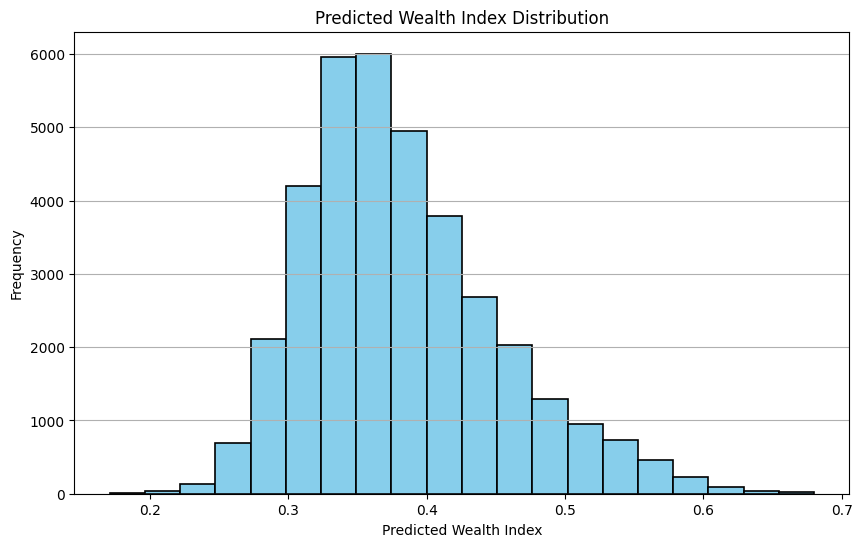

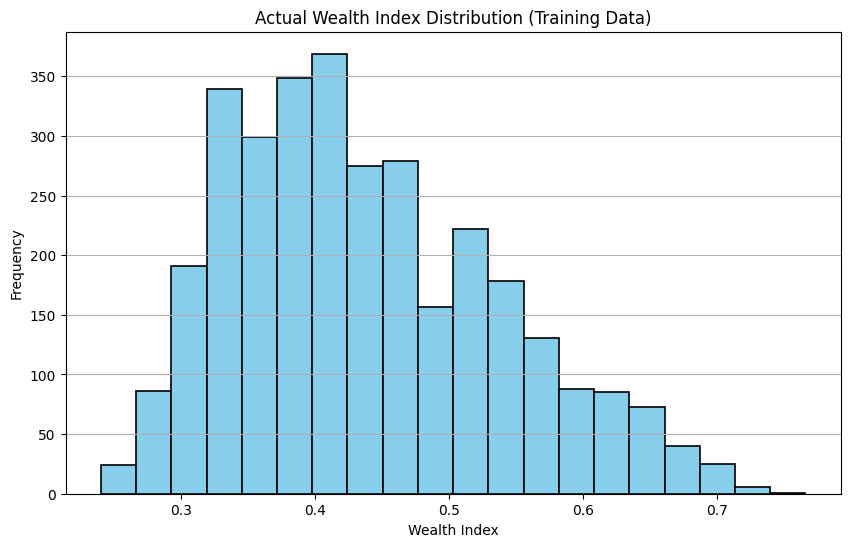

In [6]:
# plot histogam of the predicted wealth index
plt.figure(figsize=(10, 6))
plt.hist(master_gdf_only_pred['weighted_wealth'], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title("Predicted Wealth Index Distribution")
plt.xlabel("Predicted Wealth Index")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# plot histogam of the actual wealth index (labelled cells)
plt.figure(figsize=(10, 6))
plt.hist(master_gdf_only_true_label['weighted_wealth'], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title("Actual Wealth Index Distribution (Training Data)")
plt.xlabel("Wealth Index")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

/opt/anaconda3/envs/acm/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/acm/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/acm/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

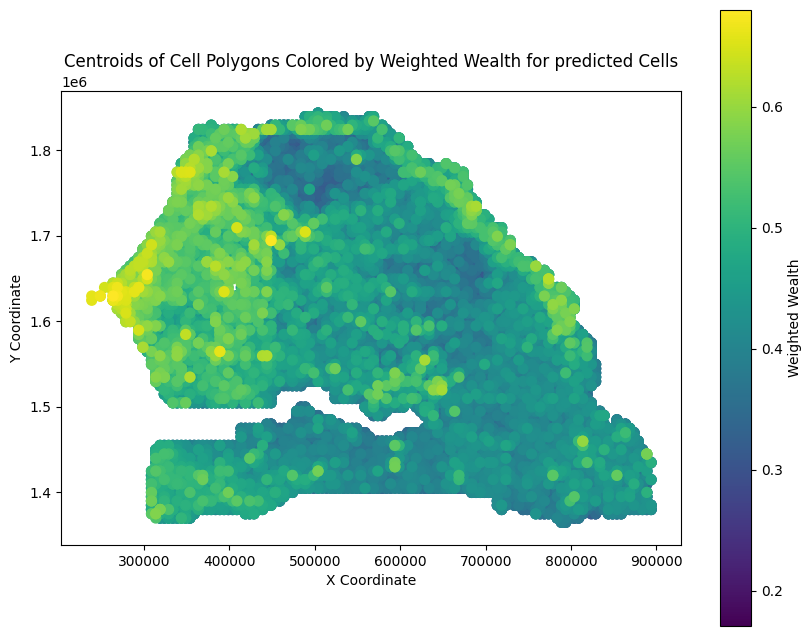

In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Calculate centroids for each polygon and add them as a new column
master_gdf_only_pred['centroid'] = master_gdf_only_pred.geometry.centroid

# Extract centroid coordinates for plotting
master_gdf_only_pred['centroid_x'] = master_gdf_only_pred.centroid.x
master_gdf_only_pred['centroid_y'] = master_gdf_only_pred.centroid.y

# Create a plot with the polygons and overlay the centroids colored by weighted wealth
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the base polygons for context (optional)
master_gdf_only_pred.plot(ax=ax, color='lightgrey', edgecolor='black')

# Scatter plot for centroids, colored by weighted wealth
scatter = ax.scatter(master_gdf_only_pred['centroid_x'], master_gdf_only_pred['centroid_y'], 
                     c=master_gdf_only_pred['weighted_wealth'], cmap='viridis', s=50)

# Add a colorbar to indicate weighted wealth values
cbar = fig.colorbar(scatter, ax=ax, label='Weighted Wealth')

ax.set_title("Centroids of Cell Polygons Colored by Weighted Wealth for predicted Cells")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
plt.show()

/opt/anaconda3/envs/acm/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/acm/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/acm/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

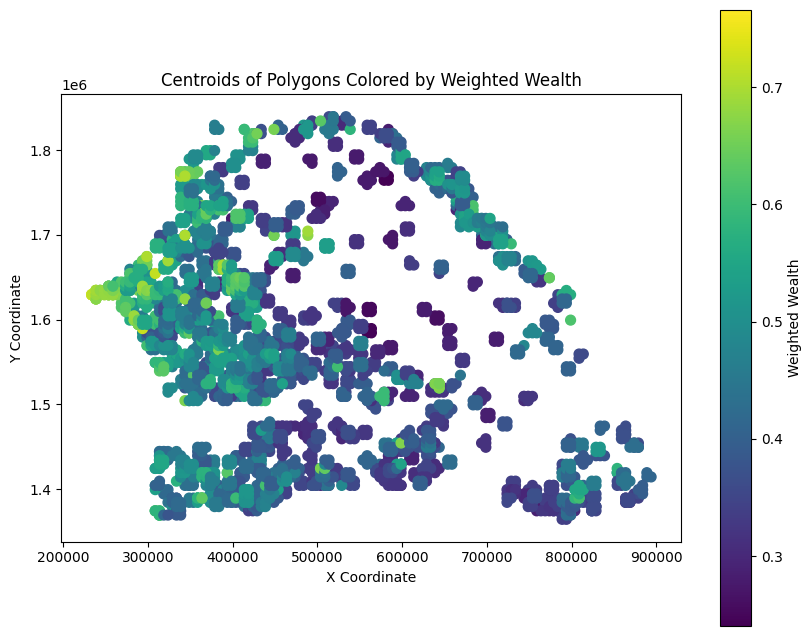

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Calculate centroids for each polygon and add them as a new column
master_gdf_only_true_label['centroid'] = master_gdf_only_true_label.geometry.centroid

# Extract centroid coordinates for plotting
master_gdf_only_true_label['centroid_x'] = master_gdf_only_true_label.centroid.x
master_gdf_only_true_label['centroid_y'] = master_gdf_only_true_label.centroid.y

# Create a plot with the polygons and overlay the centroids colored by weighted wealth
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the base polygons for context (optional)
master_gdf_only_true_label.plot(ax=ax, color='lightgrey', edgecolor='black')

# Scatter plot for centroids, colored by weighted wealth
scatter = ax.scatter(master_gdf_only_true_label['centroid_x'], master_gdf_only_true_label['centroid_y'], 
                     c=master_gdf_only_true_label['weighted_wealth'], cmap='viridis', s=50)

# Add a colorbar to indicate weighted wealth values
cbar = fig.colorbar(scatter, ax=ax, label='Weighted Wealth')

ax.set_title("Centroids of Polygons Colored by Weighted Wealth")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
plt.show()